# Multi-line regression

We are given a set of$N$ data points, where each data point$i$ has an input value$x_i$ and an output value $y_i$. We aim to fit$K$ different polynomials of degree$M-1$ to the data points, while minimizing the fitting error. The model includes the following decision variables:
-$r_i$, a continuous variable representing the error associated with data point$i$,
-$c_{k,m}$, the coefficients of the polynomials for each line$k$ and polynomial term$m$,
-$U_{i,k}$, a binary variable indicating whether data point$i$ is assigned to line$k$.

### Objective

The objective is to minimize the sum of errors $r_i$ across all data points:

$$
\text{Minimize} \quad \sum_{i=1}^{N} r_i
$$

### Constraints

1. **Polynomial Upper Bound:**
   For each data point $i$ and line $k$, the polynomial approximation must be greater than or equal to $y_i$, within an error boun $r_i$ and a large constant$BM$ (used to deactivate constraints for non-assigned points):
   
   $$
   \sum_{m=0}^{M-1} c_{k,m} x_i^m - y_i \leq r_i + BM \cdot (1 - U_{i,k}) \quad \forall i \in N, \, \forall k \in K
   $$

2. **Polynomial Lower Bound:**
   Similarly, the polynomial approximation must also be less than or equal to $y_i$, considering the error term $r_i$ and the large constant $BM$:
   
   $$
   
   \sum_{m=0}^{M-1} c_{k,m} x_i^m - y_i \geq -r_i - BM \cdot (1 - U_{i,k}) \quad \forall i \in N, \, \forall k \in K
   $$

3. **Unique Assignment:**
   Each data point$i$ must be assigned to exactly one polynomial line$k$:
   
   $$
   \sum_{k=1}^{K} U_{i,k} = 1 \quad \forall i \in N
   $$

4. **Monotonicity of Assignments:**
   The sum of data points assigned to line $k-1$ should be less than or equal to the sum of those assigned to line $k$, ensuring a hierarchical assignment of points:
   
   $$
   \sum_{i=1}^{N} U_{i,k-1} \leq \sum_{i=1}^{N} U_{i,k} \quad \forall k = 2, \ldots, K
   $$

### Variables

-$r_i \in [0, 1000]$: Continuous variables representing the fitting error for each data point$i$.

-$c_{k,m} \in [-100, 100]$: Continuous variables representing the polynomial coefficients for line $k$ and degree $m$.

-$U_{i,k} \in \{0, 1\}$: Binary variables representing whether data point $i$ is assigned to polynomial line$k$.

This problem aims to fit multiple polynomial lines to a dataset while minimizing the fitting error and ensuring each data point is assigned to only one line, respecting the constraints defined above.

In [5]:
import pandas as pd
import random

In [6]:
df=pd.DataFrame()
N = 20
df['x'] = [random.random() for i in range(N)]
df['y'] = [random.random() for i in range(N)]

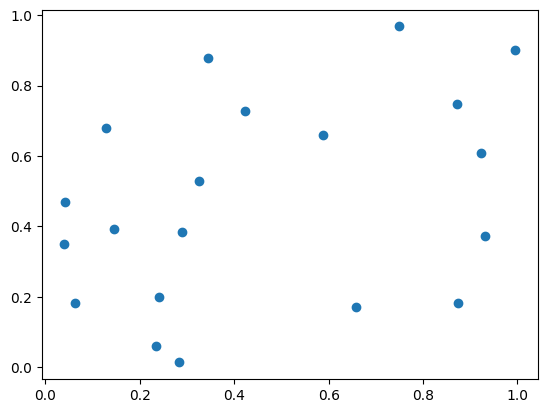

In [7]:
# plot the data
import matplotlib.pyplot as plt
plt.scatter(df['x'], df['y'])
plt.show()

In [15]:
import gurobipy as gp
from gurobipy import GRB
BM = 4
K = 3
M = 3
# Initialize the model
model = gp.Model("model")

# Define the variables
r = model.addVars(N, vtype=GRB.CONTINUOUS, lb=0, ub=1000, name="r")
c = model.addVars(K, M, vtype=GRB.CONTINUOUS, lb=-100, ub=100, name="c")
U = model.addVars(N, K, vtype=GRB.BINARY, name="U")

# Adjust indexing to match Gurobi's 0-based indexing
# C1: Sum of polynomial terms - y <= r[i] + BM * (1 - U[i,k])
for i in range(N):  # 0-based indexing for data rows
    for k in range(K):  # 0-based indexing for lines
        model.addConstr(
            gp.quicksum(c[k, m] * df.iloc[i]['x']**(m) for m in range(M)) - df.iloc[i]['y']
            <= r[i] + BM * (1 - U[i, k]), f"C1_{i}_{k}"
        )

# C2: Sum of polynomial terms - y >= -r[i] - BM * (1 - U[i,k])
for i in range(N):
    for k in range(K):
        model.addConstr(
            gp.quicksum(c[k, m] * df.iloc[i]['x']**(m) for m in range(M)) - df.iloc[i]['y']
            >= r[i] - BM * (1 - U[i, k]), f"C2_{i}_{k}"
        )

# C3: Sum of U[i,k] for each i should equal 1
for i in range(N):
    model.addConstr(gp.quicksum(U[i, k] for k in range(K)) == 1, f"C3_{i}")

# C4: Ensure that sum(U[i, k-1]) <= sum(U[i, k]) for k > 1
for k in range(1, K):  # Starting from 1 since C4 depends on k-1
    model.addConstr(
        gp.quicksum(U[i, k-1] for i in range(N)) <= gp.quicksum(U[i, k] for i in range(N)), f"C4_{k}"
    )

# Objective: Minimize the sum of r[i]
model.setObjective(gp.quicksum(r[i] for i in range(N)), GRB.MINIMIZE)

# Optimize the model
model.optimize()

# Extract solution (if needed)
if model.status == GRB.OPTIMAL:
    r_sol = model.getAttr('x', r)
    c_sol = model.getAttr('x', c)
    U_sol = model.getAttr('x', U)


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Gentoo Linux")

CPU model: Intel(R) Core(TM) i9-14900K, instruction set [SSE2|AVX|AVX2]
Thread count: 32 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 177 rows, 109 columns and 925 nonzeros
Model fingerprint: 0xd210aa1e
Variable types: 34 continuous, 75 integer (75 binary)
Coefficient statistics:
  Matrix range     [2e-03, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+00, 5e+00]
Presolve time: 0.00s
Presolved: 177 rows, 109 columns, 925 nonzeros
Variable types: 34 continuous, 75 integer (75 binary)
Found heuristic solution: objective 10.0448009

Root relaxation: objective 0.000000e+00, 102 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   32   10.04480    0.00000 

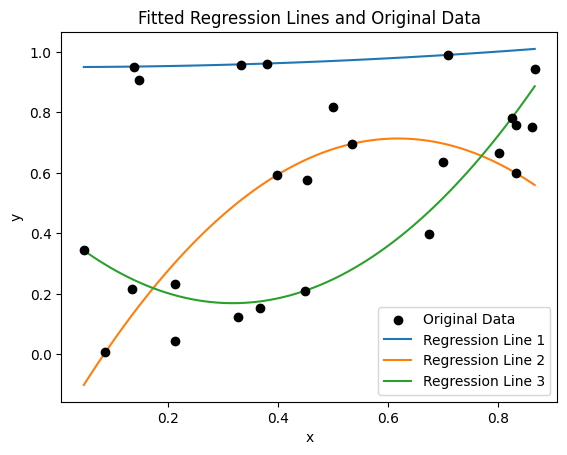

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the coefficient values from the optimized model
c_sol = model.getAttr('x', c)  # Coefficients from the Gurobi solution

# Prepare x values for plotting the lines
x_vals = np.linspace(min(df['x']), max(df['x']), 100)  # Generate 100 points between min and max x in your data

# Plot the original data points
plt.scatter(df['x'], df['y'], color='black', label='Original Data', zorder=5)

# Plot the resulting regression lines
for k in range(K):
    # Compute the y values for this regression line
    y_vals = np.zeros_like(x_vals)
    for m in range(M):
        y_vals += c_sol[k, m] * (x_vals ** m)  # Polynomial regression line based on the solution

    # Plot each line
    plt.plot(x_vals, y_vals, label=f'Regression Line {k+1}', zorder=1)

# Add labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.title('Fitted Regression Lines and Original Data')
plt.legend()

# Show the plot
plt.show()


# The N-Queens Problem

The **n-queens problem** is a classic combinatorial problem where the goal is to place `n` queens on an `n x n` chessboard such that no two queens threaten each other. This means that:

1. **Only one queen can be placed per row.**
2. **Only one queen can be placed per column.**
3. **Only one queen can be placed on each diagonal.**

## Problem Constraints

### Row Constraint
- Place exactly one queen in each row.

### Column Constraint
- Each column must contain exactly one queen. This ensures that no two queens can be in the same column.

### Diagonal Constraints
There are two diagonal directions to consider:
1. **Ascending Diagonals ("/")**
2. **Descending Diagonals ("\\")**

#### Ascending Diagonal Constraint
We need to ensure that only one queen appears on any ascending diagonal. An ascending diagonal can be represented by all cells where the sum of the row and column indices is constant, i.e.,:

$$
\text{Row} + \text{Column} = \text{constant}
$$

This means that the queens must not share any cells where the row index and column index sum up to the same value.

#### Descending Diagonal Constraint
For descending diagonals, the difference between the row and column indices is constant. This means that:

$$
\text{Row} - \text{Column} = \text{constant}
$$

Here, we also want to ensure that no two queens are placed on the same diagonal where the row and column indices subtract to the same value.

## Formalization

Let $x_{i,j}$ be a binary variable where:

-$x_{i,j} = 1$ if a queen is placed in row `i` and column `j`
-$x_{i,j} = 0$ otherwise

### Column Constraint
We impose the condition that for each column, only one queen can be placed:

$$
\sum_{i=1}^{n} x_{i,j} = 1 \quad \forall j \in \{1, 2, \dots, n\}
$$

### Ascending Diagonal Constraint
To ensure that only one queen is placed on each ascending diagonal:

$$
\sum_{\text{Row} + \text{Column} = k} x_{\text{Row}, \text{Column}} \leq 1 \quad \forall k
$$

Where $k$ is the sum of row and column indices.

### Descending Diagonal Constraint
To ensure that only one queen is placed on each descending diagonal:

$$
\sum_{\text{Row} - \text{Column} = k} x_{\text{Row}, \text{Column}} \leq 1 \quad \forall k
$$

Where $k$ is the difference between row and column indices.


Set parameter PoolSolutions to value 100
Set parameter PoolSearchMode to value 2
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Gentoo Linux")

CPU model: Intel(R) Core(TM) i9-14900K, instruction set [SSE2|AVX|AVX2]
Thread count: 32 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 46 rows, 64 columns and 256 nonzeros
Model fingerprint: 0xc537e5e0
Variable types: 0 continuous, 64 integer (64 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0000000
Presolve removed 4 rows and 0 columns
Presolve time: 0.00s
Presolved: 42 rows, 64 columns, 270 nonzeros
Variable types: 0 continuous, 64 integer (64 binary)

Root relaxation: objective 0.000000e+00, 38 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  De

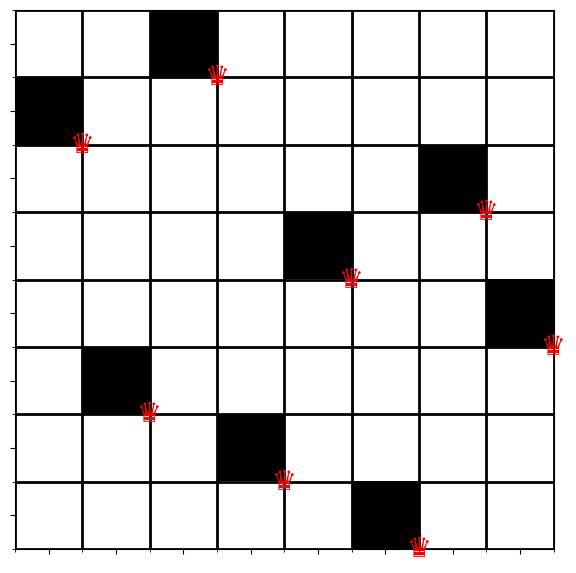

In [24]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

def solve_n_queens(N):
    # Model
    m = gp.Model("n_queens")
    # set multiple solutions
    m.setParam('PoolSolutions', 100)
    m.setParam('PoolSearchMode', 2)

    # Variables
    x = m.addVars(N, N, vtype=GRB.BINARY, name="x")

    # Constraints

    # Row constraint
    for i in range(N):
        m.addConstr(sum(x[i,j] for j in range(N)) == 1)

    # Column constraint
    for j in range(N):
        m.addConstr(sum(x[i,j] for i in range(N)) == 1)

    # Diagonal constraints
    for p in range(-N+1, N):
        m.addConstr(sum(x[i, i+p] for i in range(N) if 0 <= i+p < N) <= 1)
        m.addConstr(sum(x[i, j] for i in range(N) for j in range(N) if i+j == p+N-1) <= 1)

    # Solve model
    m.optimize()

    # Extract solution
    if m.status == GRB.OPTIMAL:
        sol = m.getAttr('x', x)
        board = np.zeros((N,N), int)
        for i in range(N):
            for j in range(N):
                if sol[i,j] > 0.5:
                    board[i,j] = 1
        return board
    else:
        return None

# Example: Solve 8-queens problem
N = 8
solution = solve_n_queens(N)
print(solution)

import matplotlib.pyplot as plt

def plot_solution(solution):
    N = solution.shape[0]
    plt.figure(figsize=(7,7))  # Adjust figure size as needed
    plt.imshow(solution, cmap='binary', interpolation='nearest')
    plt.xticks(range(N), [])
    plt.yticks(range(N), [])
    #plt.grid(color='black', linestyle='-', linewidth=1.5)
    ax = plt.gca()  # Get current axes
    ax.set_xticks(np.arange(-.5, N, 1), minor=True)
    ax.set_yticks(np.arange(-.5, N, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
    
    # Adjust the text position
    offset = 0.5
    for i in range(N):
        for j in range(N):
            if solution[i,j] == 1:
                plt.text(j + offset, i + offset, '♛', fontsize=20, ha='center', va='center', color='red')

    plt.show()

if solution is not None:
    plot_solution(solution)

# Army


1. A set of pieces (King, Rook, Queen, Knight, and Bishop) are placed on an 8x8 chessboard.
2. Each square on the board is either empty or occupied by exactly one chess piece.
3. If a square is occupied by a piece, no other piece can "attack" it, i.e., no piece can threaten any other based on their movement rules.
4. The objective is to maximize the sum of assigned values for the pieces placed on the board, where each type of piece has a different value.

### Problem Definition in LaTeX:

#### Sets:
- Let $N = \{1, 2, \dots, 64\}$ represent the set of squares on the 8x8 chessboard.
- Let $P = \{\text{K}, \text{R}, \text{Q}, \text{N}, \text{B}\}$ represent the set of chess pieces: King ($\text{K}$), Rook ($\text{R}$), Queen ($\text{Q}$), Knight ($\text{N}$), and Bishop ($\text{B}$).

#### Parameters:
- $v_p$ is the value associated with placing piece $p \in P$ on the board. For instance, $v_{\text{K}} = 14$, $v_{\text{R}} = 28$, etc.
- Define $N_{\text{attack}}^p(n)$ as the set of squares that piece $p$ can attack from square $n$. These sets differ for each piece based on their movement rules.

#### Decision Variables:
- $U_{n,p} \in \{0,1\}$: Binary variable, where $U_{n,p} = 1$ if piece $p$ is placed on square $n$, and 0 otherwise.
- $O_n \in \{0,1\}$: Binary variable, where $O_n = 1$ if square $n$ is occupied by any piece, and 0 otherwise.

#### Objective Function:
Maximize the total value of pieces placed on the board:
$$
\text{Maximize } \sum_{n \in N} \sum_{p \in P} v_p U_{n,p}
$$

#### Constraints:

1. **At most one piece per square**: Each square is either occupied by one piece or left empty.
   $$
   \sum_{p \in P} U_{n,p} \leq 1, \quad \forall n \in N
   $$
   Additionally, the square is occupied if and only if there is a piece assigned to it:
   $$
   O_n = \sum_{p \in P} U_{n,p}, \quad \forall n \in N
   $$

2. **Non-attack condition**: If a square is occupied, no piece on the board should be able to attack it. We use a Big M formulation to enforce this condition:
   
   For each piece $p$ and each square $n \in N$, let $\text{around}(n)$ be the number of pieces that can attack square $n$:
   $$
   \text{around}(n) = \sum_{m \in N_{\text{attack}}^p(n)} U_{m,p}
   $$
   
   If a square $n$ is occupied ($O_n = 1$), then no piece should be able to attack it, meaning $\text{around}(n) = 0$. This is implemented using the Big M method as follows:
   
   $$
   \text{around}(n) \leq M(1 - O_n), \quad \forall n \in N
   $$
   where $M$ is a large constant (e.g., $M = 64$) to relax the constraint when $O_n = 0$.

#### Final Problem Formulation:

$$
\begin{aligned}
    & \text{Maximize} \quad \sum_{n \in N} \sum_{p \in P} v_p U_{n,p} \\
    & \text{subject to:} \\
    & \sum_{p \in P} U_{n,p} \leq 1, \quad \forall n \in N \\
    & O_n = \sum_{p \in P} U_{n,p}, \quad \forall n \in N \\
    & \sum_{m \in N_{\text{attack}}^p(n)} U_{m,p} \leq M(1 - O_n), \quad \forall n \in N, \, \forall p \in P \\
    & U_{n,p} \in \{0,1\}, \quad O_n \in \{0,1\}, \quad \forall n \in N, \, \forall p \in P
\end{aligned}
$$

### Explanation of the Problem:
- **Objective**: Place pieces on the board in a way that maximizes their total value, while ensuring no pieces threaten each other.
- **Constraints**:
  - Each square can hold at most one piece.
  - If a square is occupied, it cannot be attacked by any other piece according to standard chess movement rules.
- **Movement Rules**: The sets $N_{\text{attack}}^p(n)$ are calculated based on each piece’s attack pattern (e.g., rooks attack in straight lines, knights attack in "L"-shapes, etc.).

Set parameter TimeLimit to value 30
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Gentoo Linux")

CPU model: Intel(R) Core(TM) i9-14900K, instruction set [SSE2|AVX|AVX2]
Thread count: 32 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 261 rows, 384 columns and 8488 nonzeros
Model fingerprint: 0x76dbf8c2
Variable types: 0 continuous, 384 integer (384 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [7e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+01]
Found heuristic solution: objective 93.0000000
Presolve removed 192 rows and 64 columns
Presolve time: 0.00s
Presolved: 69 rows, 320 columns, 4308 nonzeros
Variable types: 0 continuous, 320 integer (320 binary)
Found heuristic solution: objective 217.0000000

Root relaxation: objective 1.160637e+03, 179 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl 

H49101 29042                     281.0000000  363.00807  29.2%  36.9    4s
 59539 33333  285.65390   75  216  281.00000  363.00807  29.2%  36.3    7s
 59625 33390  286.26596  111  252  281.00000  363.00807  29.2%  36.2   10s
 59755 33486  343.74476   33  245  281.00000  343.74476  22.3%  36.5   15s
 93245 42321  325.61168   79  146  281.00000  343.74476  22.3%  41.0   20s
 141956 26803  303.63733  137  162  281.00000  343.74476  22.3%  44.8   25s

Cutting planes:
  Gomory: 1
  Cover: 169
  Clique: 593
  MIR: 194
  Flow cover: 493

Explored 178349 nodes (7601569 simplex iterations) in 27.83 seconds (68.32 work units)
Thread count was 32 (of 32 available processors)

Solution count 7: 281 276 257 ... 93

Optimal solution found (tolerance 1.00e-04)
Best objective 2.810000000000e+02, best bound 2.810000000000e+02, gap 0.0000%
Objective value: 281.0


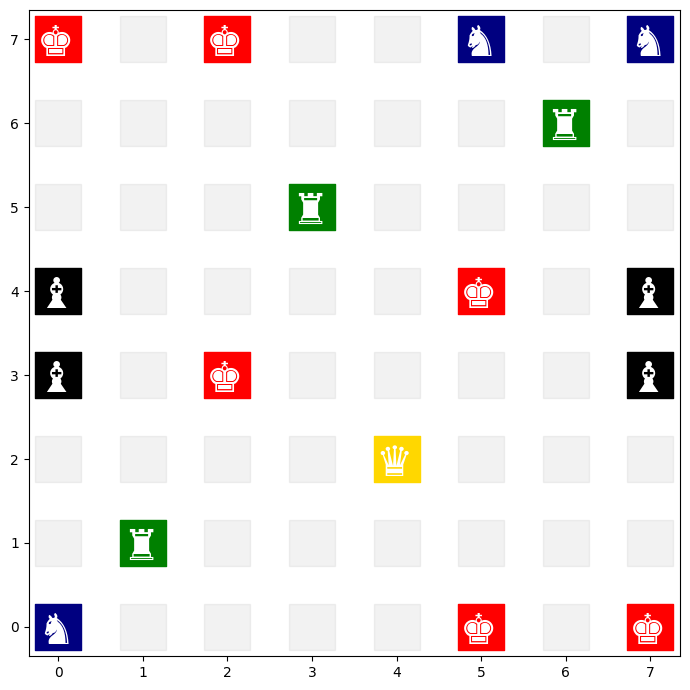

In [11]:
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np

# Step 1: Define data as per your original code
counter = 0
data = {}
for r in range(8):
    for c in range(8):
        counter += 1
        data[counter, 'X'] = c
        data[counter, 'Y'] = r

# Define knight move options
allowed = [(1, 2), (1, -2), (-1, 2), (-1, -2), (2, 1), (2, -1), (-2, -1), (-2, 1)]

# Initialize node sets for each piece's movement constraints
NR = {}
NQ = {}
Nking = {}
Nknight = {}
NB = {}

def dist(n, counter):
    return np.sqrt((data[counter, 'X'] - data[n, 'X']) ** 2 + (data[counter, 'Y'] - data[n, 'Y']) ** 2)

nodes = [n for n in range(1, 1 + 64)]

# Populate possible movement based on piece rules
for counter in nodes:
    x = data[counter, 'X']
    y = data[counter, 'Y']
    NR[counter] = [n for n in nodes if n != counter and (data[counter, 'X'] == data[n, 'X'] or data[counter, 'Y'] == data[n, 'Y'])]
    Nking[counter] = [n for n in nodes if n != counter and dist(n, counter) <= np.sqrt(2)]
    NQ[counter] = [n for n in nodes if n != counter and (data[counter, 'X'] == data[n, 'X'] or data[counter, 'Y'] == data[n, 'Y'] or abs(data[counter, 'X'] - data[n, 'X']) == abs(data[counter, 'Y'] - data[n, 'Y']))]
    Nknight[counter] = [n for n in nodes if n != counter and (data[counter, 'X'] - data[n, 'X'], data[counter, 'Y'] - data[n, 'Y']) in allowed]
    NB[counter] = [n for n in nodes if n != counter and abs(data[counter, 'X'] - data[n, 'X']) == abs(data[counter, 'Y'] - data[n, 'Y'])]

# Step 2: Create the model
model = gp.Model("Chess_Pieces_Placement")

# Variables: U[n, p] for assigning piece p to position n, and Occupied[n] indicating if position n is occupied
pieces = ['K', 'R', 'Q', 'N', 'B']
val = {'K': 14, 'R': 28, 'Q': 28, 'N': 7, 'B': 16}
symb = {'K': "\u265A", 'R': "\u265C", 'Q': "\u265B", 'N': "\u265E", 'B': "\u265D"}
U = model.addVars(nodes, pieces, vtype=GRB.BINARY, name="assign")
Occupied = model.addVars(nodes, vtype=GRB.BINARY, name="Occupied")

# Step 3: Add constraints to the model

# Ensure at least one piece is assigned to each node
for p in pieces:
    model.addConstr(gp.quicksum(U[n, p] for n in nodes) >= 1)

# Ensure each node is either occupied by one piece or not occupied at all
for n in nodes:
    model.addConstr(gp.quicksum(U[n, p] for p in pieces) == Occupied[n])
    model.addConstr(gp.quicksum(U[n, p] for p in pieces) <= 1)

# Add constraints for the movements and piece interactions
for n in nodes:
    around = gp.quicksum(U[counter, 'K'] for counter in Nking[n]) + \
             gp.quicksum(U[counter, 'R'] for counter in NR[n]) + \
             gp.quicksum(U[counter, 'Q'] for counter in NQ[n]) + \
             gp.quicksum(U[counter, 'N'] for counter in Nknight[n]) + \
             gp.quicksum(U[counter, 'B'] for counter in NB[n])
    
# Step 3: Add constraints to the model
M = 64  # A large constant (since the maximum around value could be at most all other nodes)

for n in nodes:
    around = gp.quicksum(U[counter, 'K'] for counter in Nking[n]) + \
             gp.quicksum(U[counter, 'R'] for counter in NR[n]) + \
             gp.quicksum(U[counter, 'Q'] for counter in NQ[n]) + \
             gp.quicksum(U[counter, 'N'] for counter in Nknight[n]) + \
             gp.quicksum(U[counter, 'B'] for counter in NB[n])
    
    # Big M constraint: When Occupied[n] == 1, enforce around == 0
    # When Occupied[n] == 0, relax the constraint
    model.addConstr(around <= M * (1 - Occupied[n]))
    
    # Additionally, if Occupied[n] == 1, enforce around == 0
    model.addConstr(around <= 0 + M * (1 - Occupied[n]))


# Step 4: Define the objective to maximize the value of the placed pieces
model.setObjective(gp.quicksum(val[p] * U[n, p] for n in nodes for p in pieces), GRB.MAXIMIZE)

# Step 5: Solve the model
model.setParam('TimeLimit', 30)
model.optimize()

# Step 6: Visualize the solution
if model.status == GRB.OPTIMAL or model.status == GRB.TIME_LIMIT:
    print(f"Objective value: {model.objVal}")
    
    KOLOR = ['r', 'g', 'gold', 'navy', 'k']
    plt.figure(figsize=(7, 7))
    
    for n in nodes:
        x, y = data[n, 'X'], data[n, 'Y']
        
        # If not occupied, grey out the square
        if Occupied[n].X == 0:
            plt.scatter(x, y, s=1100, marker='s', c='grey', alpha=0.1)
        
        # Plot the pieces
        for p in pieces:
            if U[n, p].X > 0:
                cc = KOLOR[pieces.index(p)]
                plt.scatter(x, y, s=1100, marker='s', c=cc)
                prop = FontProperties()
                plt.text(x - 0.25, y - 0.2, s=symb[p], color='w', fontsize=30, fontproperties=prop)

    plt.tight_layout()
    plt.show()


### Problem Objective Explanation:

The objective of this optimization problem is to **maximize the radius of a circle** that encompasses a selected subset of points on a 2D plane. The points are characterized by their coordinates $(x, y)$ and a binary category $ c \in \{0, 1\} $, which differentiates them into two groups. 

The goal is to find a subset of points such that:
- All selected points lie within a circle with center $(0.5, 0.5)$ and variable radius $R$.
- The number of selected points from each group ($c = 0$ and $c = 1$) is the same.
- The circle’s radius $R$ is maximized.

### Decision Variables:
- $ x_i \in \{0, 1\} $: Binary variable that indicates whether point $i$ is selected or not.
- $ R \in [0, 0.5] $: The radius of the circle, which we aim to maximize.
- $ \text{Count} \in [1, N] $: The number of selected points, equal between the two categories.

### Objective:
Maximize the radius $R$ of the circle:
$$
\text{Maximize } R
$$

### Constraints:
1. **Distance Constraints**: Ensure that the selected points lie within the circle. 
   - For each selected point $i$, its distance from the circle center $(0.5, 0.5)$ must be less than or equal to $R$. This is enforced through the following two constraints:
   $$
   D_i \leq R + 2(1 - x_i) - 0.01 \quad \forall i
   $$
   $$
   D_i \geq R - 2x_i + 0.01 \quad \forall i
   $$
   where $D_i$ is the Euclidean distance from the point $(x_i, y_i)$ to the circle center.

2. **Count Constraints**:
   - Ensure that the number of selected points with $ c = 0 $ equals the number of selected points with $ c = 1 $:
   $$
   \sum_{i=1}^{N} x_i (1 - c_i) = \text{Count}
   $$
   $$
   \sum_{i=1}^{N} x_i c_i = \text{Count}
   $$

$$
\text{Maximize } R
$$
subject to:
$$
D_i = \sqrt{(x_i - 0.5)^2 + (y_i - 0.5)^2} \quad \forall i
$$
$$
D_i \leq R + 2(1 - x_i) - 0.01 \quad \forall i
$$
$$
D_i \geq R - 2x_i + 0.01 \quad \forall i
$$
$$
\sum_{i=1}^{N} x_i (1 - c_i) = \text{Count}
$$
$$
\sum_{i=1}^{N} x_i c_i = \text{Count}
$$
$$
x_i \in \{0, 1\}, \quad R \in [0, 0.5], \quad \text{Count} \in [1, N]
$$

### Summary:
- The goal is to maximize the radius $R$ of a circle that contains an equal number of points from two groups. The constraints ensure that the selected points lie within the circle and that the number of selected points from each group is balanced.

Set parameter TimeLimit to value 60
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Gentoo Linux")

CPU model: Intel(R) Core(TM) i9-14900K, instruction set [SSE2|AVX|AVX2]
Thread count: 32 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 52 rows, 27 columns and 127 nonzeros
Model fingerprint: 0x578ba33b
Variable types: 2 continuous, 25 integer (25 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [5e-01, 2e+01]
  RHS range        [8e-02, 2e+00]
Found heuristic solution: objective 0.1882047
Presolve removed 49 rows and 24 columns
Presolve time: 0.00s
Presolved: 3 rows, 3 columns, 6 nonzeros
Found heuristic solution: objective 0.3074787
Variable types: 1 continuous, 2 integer (2 binary)

Root relaxation: objective 3.826124e-01, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth 

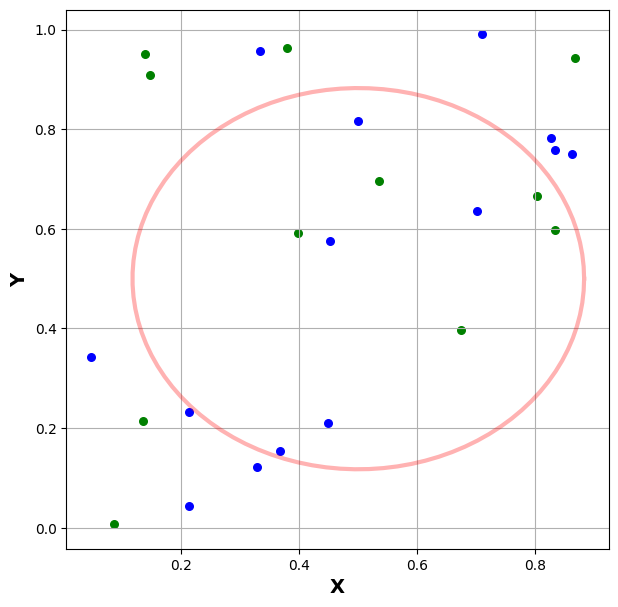

In [12]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import time

# Data generation
N = 25
df = pd.DataFrame()
df['x'] = [random.random() for i in range(N)]
df['y'] = [random.random() for i in range(N)]
df['c'] = [random.randint(0, 1) for i in range(N)]

# Initialize the model
model = gp.Model("Circle_Optimization")

# Decision Variables
x_vars = model.addVars(N, vtype=GRB.BINARY, name="x")
R = model.addVar(vtype=GRB.CONTINUOUS, name="R", lb=0, ub=0.5)
Count = model.addVar(vtype=GRB.CONTINUOUS, name="Count", lb=1, ub=N)

# Circle center
x0, y0 = 0.5, 0.5

# Distance calculation
D = {}
for i in range(N):
    D[i] = np.sqrt((df.loc[i, 'x'] - x0) ** 2 + (df.loc[i, 'y'] - y0) ** 2)

# Constraints

# C1 and C1A - The distance constraints for selecting points inside the circle
for i in range(N):
    model.addConstr(D[i] <= R + 2 * (1 - x_vars[i]) - 0.01, name=f"C1_{i}")
    model.addConstr(D[i] >= 0.01 + R - 2 * x_vars[i], name=f"C1A_{i}")

# C2 - Count of selected points where c == 0
model.addConstr(gp.quicksum(x_vars[i] * (1 - df.loc[i, 'c']) for i in range(N)) == Count, name="C2")

# C3 - Count of selected points where c == 1
model.addConstr(gp.quicksum(x_vars[i] * df.loc[i, 'c'] for i in range(N)) == Count, name="C3")

# Objective - Maximize the radius R
model.setObjective(R, GRB.MAXIMIZE)

# Solve the model
model.setParam('TimeLimit', 60)
model.optimize()

# Check the solution status
if model.status == GRB.OPTIMAL:
    print('Optimal solution found.')
elif model.status == GRB.INFEASIBLE:
    print('Infeasible solution.')
else:
    print(f'Solver status: {model.status}')

# Display results
print("Optimal R:", R.X)
print("Optimal Count:", Count.X)

# Plotting the result
A = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
plt.figure(figsize=(7, 7))

# Circle plot
r = R.X
theta = np.linspace(0, 2 * np.pi, 100)
X = x0 + r * np.cos(theta)
Y = y0 + r * np.sin(theta)
plt.plot(X, Y, c='r', lw=3, alpha=0.3)

# Points plot
for i in range(N):
    x_coord = df.loc[i, 'x']
    y_coord = df.loc[i, 'y']
    color = 'b' if df.loc[i, 'c'] == 0 else 'g'
    plt.scatter(x_coord, y_coord, s=30, c=color)

plt.xlabel('X', fontweight='bold', fontsize=14)
plt.ylabel('Y', fontweight='bold', fontsize=14)
plt.grid()
plt.show()


### Problem Definition:

#### Sets:
- Let $ W $ be the set of words.
- Let $ C $ be the set of unique letters (e.g., $ C = \{a, b, c, ..., z\} $).
- Let $ \text{Word}(w, c) $ be an indicator function that is 1 if letter $ c $ is present in word $ w $, and 0 otherwise.

#### Decision Variables:
- $ x_w \in \{0, 1\} $: Binary variable, where $ x_w = 1 $ if word $ w $ is selected in the solution, and 0 otherwise.

#### Objective Function:
Maximize the number of selected words:
$$
\text{Maximize } \sum_{w \in W} x_w
$$

#### Constraints:
For each letter $ c \in C $, ensure that it is used by at most one word:
$$
\sum_{w \in W \, | \, \text{Word}(w, c) = 1} x_w \leq 1, \quad \forall c \in C
$$


In [13]:
import gurobipy as gp
from gurobipy import GRB

# Example data
words = ["apple", "bat", "cat", "dog", "ear", "fan"]
letters = set("abcdefghijklmnopqrstuvwxyz")

# Preprocessing: Create a dictionary for words and their letter usage
word_letters = {w: set(w) for w in words}
letter_words = {c: [] for c in letters}

for word in words:
    for letter in word_letters[word]:
        letter_words[letter].append(word)

# Create Gurobi model
model = gp.Model("Unique_Letters_Words")

# Decision variables: x_w = 1 if word w is selected, 0 otherwise
x = model.addVars(words, vtype=GRB.BINARY, name="x")

# Constraints: Ensure each letter is used by at most one word
for letter in letters:
    if letter_words[letter]:  # Only if the letter is used in any word
        model.addConstr(gp.quicksum(x[word] for word in letter_words[letter]) <= 1, 
                        name=f"letter_{letter}")

# Objective: Maximize the number of selected words
model.setObjective(gp.quicksum(x[word] for word in words), GRB.MAXIMIZE)

# Solve the model
model.optimize()

# Check solution and print the selected words
if model.status == GRB.OPTIMAL:
    selected_words = [word for word in words if x[word].X > 0.5]
    print(f"Optimal subset of words with unique letters: {selected_words}")
else:
    print("No optimal solution found.")


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Gentoo Linux")

CPU model: Intel(R) Core(TM) i9-14900K, instruction set [SSE2|AVX|AVX2]
Thread count: 32 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 13 rows, 6 columns and 19 nonzeros
Model fingerprint: 0x4151ffb1
Variable types: 0 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 2.0000000
Presolve removed 13 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 32 available processors)

Solution count 1: 2 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.000000000000e+00, best bound 2.000000000000e+00, gap 0.0000%
Optimal subset of words with unique letters: ['bat', 'dog']


# MST

Given a connected, undirected graph $G = (V, E)$, where $V$ is the set of vertices (nodes) and $E$ is the set of edges, with each edge $(i, j) \in E$ having an associated weight $w_{ij}$, the goal is to find a spanning tree $T \subseteq E$ that:


- Connects all the vertices in $V$.
- Has no cycles.
- Minimizes the total weight of the selected edges.

The total weight of the spanning tree $T$ is given by:

$$
\text{Total weight of } T = \sum_{(i, j) \in T} w_{ij}
$$

The objective is to minimize this sum.

\section{Integer Programming Formulation}

We can formulate the Minimum Spanning Tree problem as an Integer Programming (IP) model. Let binary decision variables $x_{ij}$ represent whether the edge $(i, j)$ is included in the spanning tree:

$$
x_{ij} = \begin{cases} 
1 & \text{if edge } (i, j) \text{ is in the spanning tree}, \\
0 & \text{otherwise}.
\end{cases}
$$

The objective is to minimize the total weight of the selected edges:

$$
\text{Minimize } \sum_{(i, j) \in E} w_{ij} x_{ij}
$$

subject to the following constraints:


- *Cardinality constraint:* The number of selected edges must be equal to $|V| - 1$, ensuring a tree is formed:
    $$
    \sum_{(i, j) \in E} x_{ij} = |V| - 1
    $$
    
- *Connectivity constraint:* The selected edges must connect all the vertices. For each subset $S \subseteq V$, at least one edge must connect $S$ to its complement $V \setminus S$:
    $$
    \sum_{(i, j) \in \delta(S)} x_{ij} \geq 1 \quad \forall S \subset V
    $$
    where $\delta(S)$ is the set of edges that connect vertices in $S$ to vertices in $V \setminus S$. This constraint ensures that the selected edges form a connected subgraph.

- *Cycle constraint:* The selected edges must not form any cycles. This can be enforced through additional constraints or handled using specialized algorithms (e.g., subtour elimination in the case of smaller instances). A simple approach is to ensure that the solution contains exactly $|V| - 1$ edges, which is sufficient to avoid cycles in a connected graph.




Set parameter PoolSearchMode to value 1
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Gentoo Linux")

CPU model: Intel(R) Core(TM) i9-14900K, instruction set [SSE2|AVX|AVX2]
Thread count: 32 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 6 rows, 7 columns and 21 nonzeros
Model fingerprint: 0x232c3f14
Variable types: 0 continuous, 7 integer (7 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 7e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 5 rows, 7 columns, 17 nonzeros
Variable types: 0 continuous, 7 integer (7 binary)
Found heuristic solution: objective 15.0000000

Root relaxation: objective 1.200000e+01, 2 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Ti

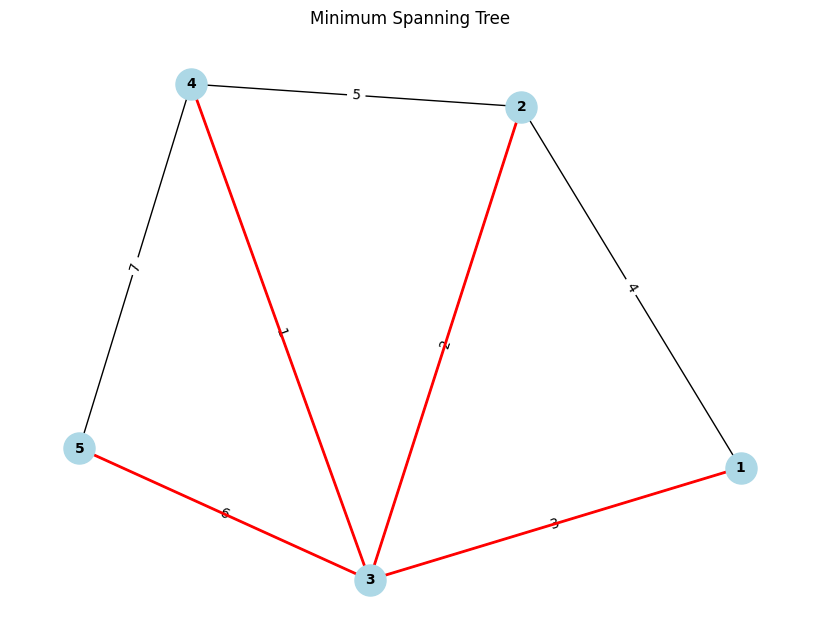

Selected edges in the Minimum Spanning Tree:
Edge (1, 3) with weight 3
Edge (2, 3) with weight 2
Edge (3, 4) with weight 1
Edge (3, 5) with weight 6


In [23]:
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
import matplotlib.pyplot as plt

# Define the data for the graph (edges and weights)
edges, weights = gp.multidict({
    (1, 2): 4,
    (1, 3): 3,
    (2, 3): 2,
    (2, 4): 5,
    (3, 4): 1,
    (3, 5): 6,
    (4, 5): 7
})

# Nodes in the graph
nodes = [1, 2, 3, 4, 5]

# Create a new model
m = gp.Model("mst")
# maximum number of solutions
m.setParam('PoolSearchMode', 1)
m.setParam('PoolSolutions', 10)

# Create variables for the edges, x[i,j] = 1 if edge (i,j) is in the MST
x = m.addVars(edges, vtype=GRB.BINARY, name="x")

# Set objective to minimize the total weight of the selected edges
m.setObjective(gp.quicksum(x[i, j] * weights[i, j] for i, j in edges), GRB.MINIMIZE)

# Add degree constraints to ensure each node is connected to the tree
# No cycles allowed: at most (n-1) edges in the solution (avoiding cycles)
m.addConstr(gp.quicksum(x[i, j] for i, j in edges) == len(nodes) - 1)

# Add connectivity constraints: For each node set, enforce that at least one edge connects the set to its complement
for node in nodes:
    m.addConstr(gp.quicksum(x[i, j] for i, j in edges if i == node or j == node) >= 1, name=f"connect_{node}")

# Optimize the model
m.optimize()

# ge
# Store the selected edges
selected_edges = [(i, j) for i, j in edges if x[i, j].x > 0.5]

solution_count = m.SolCount
for i in range(solution_count):
    m.setParam('SolutionNumber', i)
    print(f"Solution {i+1}:")
    for i, j in edges:
        if x[i, j].xn > 0.5:
            print(f"Edge ({i}, {j}) with weight {weights[i, j]}")
    print()
# Create a NetworkX graph from the edges
G = nx.Graph()

# Add edges to the graph with weights
for i, j in edges:
    G.add_edge(i, j, weight=weights[i, j])

# Get positions for nodes in a circular layout
pos = nx.spring_layout(G, seed=42)

# Plot the original graph with edge labels
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(i, j): weights[i, j] for i, j in edges})

# Highlight the edges in the MST
mst_edges = [(i, j) for (i, j) in selected_edges]
nx.draw_networkx_edges(G, pos, edgelist=mst_edges, edge_color='red', width=2)

# Display the plot
plt.title("Minimum Spanning Tree")
plt.show()

# Print the selected edges in the MST
if m.status == GRB.OPTIMAL:
    print("Selected edges in the Minimum Spanning Tree:")
    for i, j in selected_edges:
        print(f"Edge ({i}, {j}) with weight {weights[i, j]}")

# return multiples solutions
